As we saw previous that the model after the long process of preprocessing and feature manipulation 

and modeling still not achieving the best performance in terms of auc for the massive imbalance 

in the dataset so here i will try another idea of changing the formulation of the business problem

from classification problem to anomaly detection one where the non defaultor will be treated as usual

datapoint and defaultors will be treated as anomalies.

In [5]:
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
import plotly.express as px
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [6]:
data=pd.read_csv("../Data/Final_prepared_data.csv")
data.set_index("SK_ID_CURR",inplace=True)

In [7]:
features=data.columns.tolist()
features.remove("TARGET")

In [8]:
data.CODE_GENDER.replace({"XNA":np.nan},inplace=True)
data.NAME_FAMILY_STATUS.replace({"Unknown":np.nan},inplace=True)
data.ORGANIZATION_TYPE.replace({"XNA":np.nan},inplace=True)

In [9]:
y=data.loc[:,'TARGET']
X=data.drop('TARGET',axis=1)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
Categorical_features=[f for f in X_train.columns  if X_train[f].dtype=='O']
Numerical_features=[f for f in X_train.columns  if X_train[f].dtype!='O' and f!='TARGET']

In [12]:
cat_imputer = SimpleImputer( missing_values=np.nan,strategy='most_frequent')
num_imputer = SimpleImputer( missing_values=np.nan,strategy='median')

In [13]:
OEncoder=OrdinalEncoder(handle_unknown='skip')

# Isolated random forrest

We will use isolated random forrest model to detect anaomlies this model built on two assumptions

1-data has small number of anaomlies

2-anaomlies has different values and easy to be separated 

the most important hyperparameters in this model is the contamination which the precentage of 

outliers could present in the data which can be set according to domain knowledege 

we will set it as 0.1 .

In [14]:
Isolated_rf=IsolationForest(random_state=22,contamination=float(0.1))

# Full_Pipeline

In [15]:
categorical_transformer = Pipeline(
    steps=[
        ('catimputer', cat_imputer),
        ('ordinal', OEncoder)])


numeric_transformer = num_imputer

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformers', numeric_transformer, Numerical_features),
        ('categorical_transformers', categorical_transformer, Categorical_features),
    ])

In [17]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', Isolated_rf)])
pipeline.fit(X_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_transformers',
                                                  SimpleImputer(strategy='median'),
                                                  ['EXT_SRC_TOT',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3', 'DAYS_BIRTH',
                                                   'DAYS_ID_PUBLISH',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'HOUR_APPR_PROCESS_START',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_ANNUITY',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'NEW_CREDIT_TO_ANNUI...
     

In [18]:
X_train['anomaly_scores'] = pipeline.decision_function(X_train)
X_train['anomaly'] = pipeline.predict(X_train.iloc[:,:-1])

# Results of finding anomalies

In [19]:
X_train['anomaly'].value_counts()

 1    221407
-1     24601
Name: anomaly, dtype: int64

In [20]:
train_scores_df=X_train.loc[:, ['anomaly_scores','anomaly'] ]

In [21]:
transformed_train_df=pipeline['preprocessor'].transform(X_train.iloc[:,:-2])

In [22]:
transformed_train_df=pd.DataFrame(transformed_train_df,columns=features)

In [23]:
Sc=StandardScaler()
train_scaled= Sc.fit_transform(transformed_train_df)

# Test_data

In [24]:
X_valid['anomaly_scores'] = pipeline.decision_function(X_valid)
X_valid['anomaly'] = pipeline.predict(X_valid.iloc[:,:-1])

In [84]:
X_valid.anomaly.value_counts()

 1    55222
-1     6281
Name: anomaly, dtype: int64

# Visualizing Output

Now we will run tsne to make embedding to high dimension data to 2d data that can be

visualized without lossing the relationship between them.


note : we used tsne to keep non linear relations between features if we are sure

that relations are linear we could use pca instead.

In [85]:
transformed_test_df=pipeline['preprocessor'].transform(X_valid.iloc[:,:-2])
X_valid_scaled=Sc.transform(transformed_test_df)

In [86]:
tsne_projection = TSNE(n_components=2,  
                       n_jobs=-1, 
                       random_state=0).fit_transform(X_valid_scaled)



In [87]:
tsne_projection

array([[-32.50793 , -14.519044],
       [-36.791817,  -6.07785 ],
       [ 27.662355,  21.101864],
       ...,
       [ 10.713003, -13.132283],
       [ 19.25799 ,  10.090052],
       [-21.393896, -14.112317]], dtype=float32)

In [88]:
tsne_projection_df=pd.DataFrame(tsne_projection,columns=['pro1','pro2'])

In [3]:
tsne_projection_df=pd.read_csv("../Data/tsne_df.csv")

In [25]:
px.scatter(x=tsne_projection_df['pro1'],y=tsne_projection_df['pro2'],color=X_valid['anomaly'])

Blue points represents defaulters while yellow ones are non-defaulters.

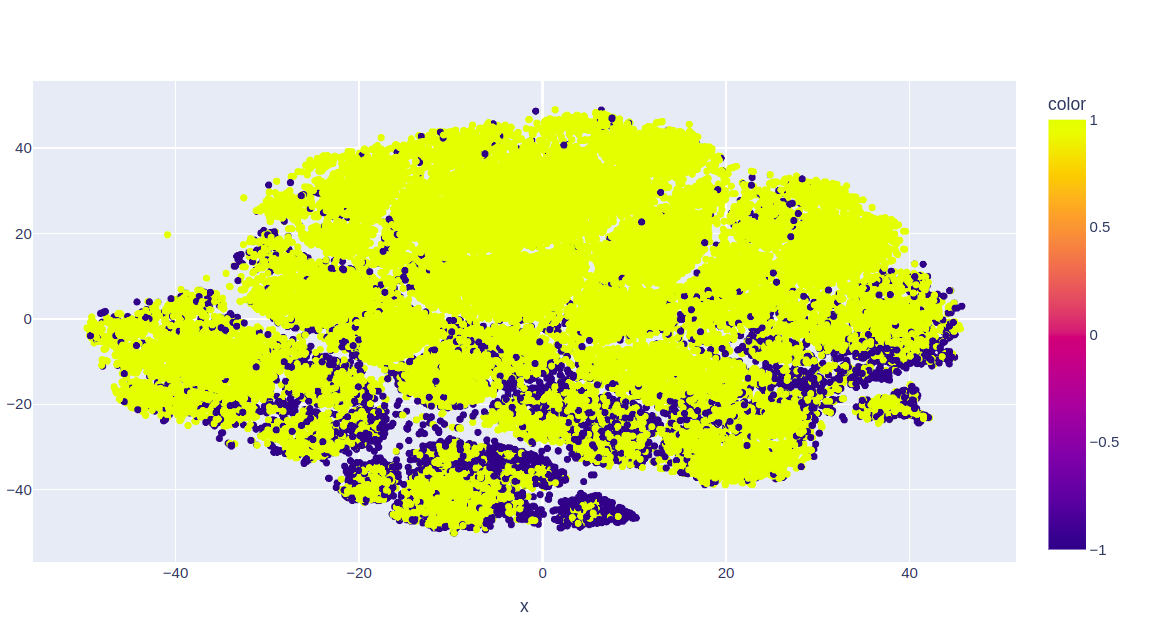

In [26]:
from IPython.display import Image
Image(filename='../Results/tsne_op.png') 